In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import load_dataset
from torch_geometric.data import Data
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from utils import (
    visualize_graph_with_pyvis_node_features,
    visualize_graph_with_pyvis_edge_features,
    aggregate_edge_features_by_node,
)  # pip install pyvis
from IPython.display import clear_output
from train_test_val import (
    train,
    evaluate,
    test,
    train_edges,
    evaluate_edges,
    test_edges,
    test_add_edge_to_nodes,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import webbrowser
import csv
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns

In [3]:
# !pip install pyvis ##for the graph visualization

In [4]:
dataset_hf = load_dataset("graphs-datasets/MUTAG")
dataset_pg_list = [Data(graph) for graph in dataset_hf["train"]]

Visualize mutagenic vs non-mutagenic graph

In [5]:
dataset_hf["train"][0]["y"]  # 1 label, 0 index = MUTAGENIC

[1]

In [6]:
dataset_hf["train"][1]["y"]  # 0 label, 1 index = NON-MUTAGENIC

[0]

In [ ]:
## CAUTION: JUMPSCARE

mutagenic_graph = 0
visualize_graph_with_pyvis_node_features(
    dataset_hf["train"],
    mutagenic_graph,
    name="mutagenic_graph.html",
)

webbrowser.open("mutagenic_graph.html")

non_mutagenic_graph = 1
visualize_graph_with_pyvis_node_features(
    dataset_hf["train"],
    non_mutagenic_graph,
    name="non_mutagenic_graph.html",
)

webbrowser.open("non_mutagenic_graph.html")

# Note: I have to do it with webbrowser since there is an issue with pyvis and jupyter notebook in VSCode thats unsolved.

# Part 1: Implementing Different Graph Convolution and Pooling Layers

-------------------------------------------------

## 1.1 Normal Convolution

$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \sum_{u\in N(v)} \frac{\mathbf{h}_u^{(l)}}{|N(v)|} + \mathbf{B}_l \mathbf{h}_v^{(l)} \right),
$$

$$
H^{(l+1)} = \sigma\left( \tilde{A}H^{(l)}W_l^\top + H^{(l)}B_l^\top \right).
$$

where $v$ indexs the node, $l$ the layer, $\mathbf{h}$ are the node embeddings, $\sigma$ is a non-linearity, $N(v)$ is the set of neighbor of node $v$, and $\mathbf{W}$ and $\mathbf{B}$ are the trainable weight matrices of the layer.

In [7]:
class GraphConv(nn.Module):
    """Basic graph convolutional layer implementing the simple neighborhood aggregation."""

    def __init__(self, in_features, out_features, activation=None):
        """
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        self.activation = activation

        self.weight = nn.Linear(in_features, out_features, bias=False)
        nn.init.xavier_uniform_(self.weight.weight)
        self.bias = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x, adj):
        """
        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        adj = adj / adj.sum(1, keepdim=True).clamp(min=1)
        x_agg = torch.matmul(adj, x)

        x = self.weight(x_agg) + self.bias(x)

        if self.activation is not None:
            x = self.activation(x)
        return x

## 1.2 GraphSAGE

Start by the graph convolutional layer below. It should take as argument an arbitrary aggregation method.

The equation for the GraphSAGE layer is:
$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \cdot \mathrm{CONCAT} \left[\mathbf{h}_v^{(l)}, \mathrm{AGG} \left(\left\{\mathbf{h}_u^{(l)}, \forall u\in N(v) \right\}\right) \right] \right),
$$
where $v$ index the node, $l$ the layer, $\mathbf{h}$ are the node embeddings, $\sigma$ is a non-linearity, $N(v)$ is the set of neighbor of node $v$, and $\mathbf{W}$ is the trainable weight matrix of the layer. $\mathrm{CONCAT}$ is the concatenation operation, while $\mathrm{AGG}$ is an arbitrary aggregation function.

In [8]:
class GraphSAGEConv(nn.Module):
    def __init__(self, in_features, out_features, activation=None, aggregation="mean"):
        """
        Args:
            in_features (int): The number of input features.
            out_features (int): The number of output features.
            activation (callable, optional): An activation function. Default is None.
        """
        super(GraphSAGEConv, self).__init__()
        self.aggregation = aggregation
        self.weight = nn.Linear(2 * in_features, out_features)
        nn.init.xavier_uniform_(self.weight.weight)
        self.activation = activation

    def forward(self, x, adj):
        """
        Args:
            x (torch.Tensor): The input features.
            adj (torch.Tensor): The adjacency matrix.

        Returns:
            torch.Tensor: The output features after the GraphSAGE convolution.
        """
        x_agg = self.aggregate(x, adj)

        x_concat = torch.cat([x, x_agg], dim=1)

        x_out = self.weight(x_concat)

        if self.activation:
            x_out = self.activation(x_out)

        return x_out

    def aggregate(self, x, adj):  # room for improvement
        # normalize adj matrix
        """
        Args:
            x (torch.Tensor): The input features.
            adj (torch.Tensor): The adjacency matrix.

        Returns:
            torch.Tensor: The aggregated features.
        """
        adj = adj / adj.sum(1, keepdim=True).clamp(min=1)
        if self.aggregation == "mean":
            x_agg = torch.matmul(adj, x)

        elif self.aggregation == "max":
            edge_index = torch.triu(adj).nonzero(as_tuple=False).t()
            x_agg = torch.zeros_like(x)
            # Loop on all nodes
            for i in range(x_agg.shape[0]):
                neighbors = x[edge_index[1, edge_index[0] == i]]
                if neighbors.shape[0] > 0:
                    x_agg[i] = neighbors.max(dim=0)[0]

        return x_agg

## 1.3 Attention-based Convolution

Attention-based Convolution applies attention mechanisms to neighbor
aggregation. The equation for Attention-based Convolution at layer l can
be defined as follows:
$$
h'_{v} = W h_{v}
$$

The attention coefficients between two nodes \( i \) and \( j \) can be computed as:
$$
e_{ij} = \text{LeakyReLU}\left( a^T [h'_{i} \| h'_{j}] \right)
$$

$$
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in N(i)} \exp(e_{ik})}
$$

Features for each node are computed by weighting the transformed features \( h' \) by the attention coefficients and aggregating:

$$
h''_{i} = \sigma \left( \sum_{j \in N(i)} \alpha_{ij} h'_{j} \right)
$$


In [9]:
class AttentionConv(nn.Module):
    def __init__(self, in_features, out_features):
        """
        Args:
            in_features (int): The number of input features.
            out_features (int): The number of output features.
        """
        super(AttentionConv, self).__init__()

        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        nn.init.xavier_uniform_(self.weight.data, gain=1.414)

        # Attention mechanism parameters
        self.a = nn.Parameter(torch.Tensor(2 * out_features, 1))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU()

    def forward(self, x, adj):
        """
        Args:
            x (torch.Tensor): The input features.
            adj (torch.Tensor): The adjacency matrix.

        Returns:
            torch.Tensor: The output features after applying the attention mechanism.
        """
        h = torch.mm(x, self.weight)
        N = h.size()[0]

        # attention
        a_input = torch.cat(
            [h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1
        ).view(N, -1, 2 * h.size(1))
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        I = torch.eye(N, device=adj.device)
        e = e.masked_fill(I.bool(), float("-inf"))

        attention = F.softmax(e, dim=1)

        h_prime = torch.matmul(attention, h)

        return h_prime

## 1.4 Mean Pooling and 1.5 Max Pooling

In [10]:
def mean_pooling(x):
    """
    Compute graph-level representation using mean pooling.

    Args:
        x (Tensor): Input node features of shape (num_nodes, in_features).

    Returns:
        Tensor: Graph-level representation (mean of all node features) of shape (in_features,).
    """
    sum_features = torch.sum(x, dim=0, keepdim=True)
    num_nodes = x.size(0)
    mean_representation = sum_features / num_nodes

    return mean_representation


def max_pooling(x):
    """
    Compute graph-level representation using max pooling.

    Args:
        x (Tensor): Input node features of shape (num_nodes, in_features).

    Returns:
        Tensor: Graph-level representation (maximum value across nodes for each feature dimension) of shape (feature_dim,).
    """
    max_features, _ = torch.max(x, dim=0, keepdim=True)

    return max_features

# Part 2: Custom Network Design with Node Features

-----------------------

## 2.1 Custom(izable) Network Architecture

In [11]:
class GraphClassifier(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features,
        num_layers=2,
        layer_type="GraphConv",  # default
        pooling="mean",  # default
    ):
        """
        Initialize the Graph Classifier.

        Args:
            in_features (int): Number of input node features.
            hidden_features (int): Number of hidden node features.
            num_layers (int): Number of graph convolutional layers.
            layer_type (str): Type of graph convolutional layer ('GraphConv', 'AttentionConv', 'GraphSAGEConv').
            pooling (str): Pooling method ('mean' or 'max').
        """
        super(GraphClassifier, self).__init__()

        self.layers = nn.ModuleList()

        for _ in range(num_layers):
            if layer_type == "GraphConv":
                self.layers.append(
                    GraphConv(
                        in_features if len(self.layers) == 0 else hidden_features,
                        hidden_features,
                        F.relu,
                    )
                )
            elif layer_type == "AttentionConv":
                self.layers.append(
                    AttentionConv(
                        in_features if len(self.layers) == 0 else hidden_features,
                        hidden_features,
                    )
                )
            elif layer_type == "GraphSAGEConv":
                self.layers.append(
                    GraphSAGEConv(  # can choose aggregation, default = mean
                        in_features if len(self.layers) == 0 else hidden_features,
                        hidden_features,
                        F.relu,
                    )
                )

        if pooling == "mean":
            self.pooling = mean_pooling
        elif pooling == "max":
            self.pooling = max_pooling
        else:
            raise ValueError("Invalid pooling type.")

        self.fc = nn.Linear(hidden_features, 1)  # binary classification

    def forward(self, x, adj):
        """
        Forward propagation for the graph.

        Args:
            x (Tensor): Node features, shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Binary prediction for the entire graph, shape (1).
        """

        for layer in self.layers:
            x = layer(x, adj)

        x = self.pooling(x)

        x = self.fc(x)

        return x

## 2.2 Data Partitioning

### 2.2.1 Define Class

In [12]:
class GraphDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        node_feat = torch.tensor(data.x["node_feat"])
        edge_index = torch.tensor(data.x["edge_index"])
        edge_attr = torch.tensor(data.x["edge_attr"])
        y = torch.tensor(data.x["y"])

        num_nodes = data.x["num_nodes"]
        adj_matrix = torch.zeros(num_nodes, num_nodes)
        adj_matrix[edge_index[0], edge_index[1]] = 1

        # Adjacency matrix for the edge features with shape [num_nodes, num_nodes, num_edge_features]
        adj_matrix_edges = torch.zeros(
            (num_nodes, num_nodes, edge_attr.shape[1]), dtype=torch.float32
        )
        for idx, (src, tgt) in enumerate(zip(edge_index[0], edge_index[1])):
            adj_matrix_edges[src, tgt] = edge_attr[idx]

        return node_feat, edge_index, edge_attr, y, adj_matrix, adj_matrix_edges

### 2.2.2 Train-Val-Test Stratified Split

In [13]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

full_dataset = GraphDataset(dataset_pg_list)

ys = []
for data in dataset_pg_list:
    ys.append(data.x["y"])

test_and_val_ratio = val_ratio + test_ratio
val_adjusted_ratio = val_ratio / test_and_val_ratio

train_indices, temp_indices = train_test_split(
    range(len(dataset_pg_list)),
    test_size=test_and_val_ratio,
    stratify=ys,
    random_state=42,
)

val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=1.0 - val_adjusted_ratio,
    stratify=[ys[i] for i in temp_indices],
    random_state=42,
)

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=True
)  # batch_size=1 to load 1 graph at a time
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Comment: Since the data is unbalanced, I will give more importance to F1-score instead of accuracy since it can be misleading. Its worth mentioning that f1 too can be misleading because of the imbalance (majority class is positive), but I will also print out the confusion matrices to confirm the results.

## 2.3 Hyperparameter Tuning

In [14]:
all_results_nodes = []

### 2.3.1 Baseline Model

In [15]:
model = GraphClassifier(
    in_features=7,
    hidden_features=32,
    num_layers=1,
    layer_type="GraphConv",
    pooling="mean",
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
num_epochs = 30
train_losses = []
val_losses = []
val_f1s = []
train_f1s = []
train_f1 = []
val_f1 = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_f1 = train(model, train_loader, optimizer)
    val_loss, val_accuracy, val_f1 = evaluate(model, val_loader)
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train F1: {train_f1}, Train Accuracy: {train_accuracy}, Val F1: {val_f1}, Val Accuracy: {val_accuracy}"
    )
    val_f1s.append(val_f1)
    train_f1s.append(train_f1)

results = {
    "name": "Baseline",
    "num_layers": 1,
    "learning_rate": 0.01,
    "layer_type": "GraphConv",
    "hidden_features": 32,
    "pooling": "mean",
    "val_accuracy": val_accuracy,
    "val_f1": val_f1,
}
all_results_nodes.append(results)

Epoch 1/30, Train F1: 0.7609756097560976, Train Accuracy: 0.6259541984732825, Val F1: 0.8085106382978724, Val Accuracy: 0.6785714285714286
Epoch 2/30, Train F1: 0.7981220657276995, Train Accuracy: 0.6717557251908397, Val F1: 0.8085106382978724, Val Accuracy: 0.6785714285714286
Epoch 3/30, Train F1: 0.8223350253807107, Train Accuracy: 0.732824427480916, Val F1: 0.7777777777777778, Val Accuracy: 0.7142857142857143
Epoch 4/30, Train F1: 0.8297872340425532, Train Accuracy: 0.7557251908396947, Val F1: 0.7368421052631579, Val Accuracy: 0.6428571428571429
Epoch 5/30, Train F1: 0.8633879781420765, Train Accuracy: 0.8091603053435115, Val F1: 0.8372093023255814, Val Accuracy: 0.75
Epoch 6/30, Train F1: 0.8253968253968255, Train Accuracy: 0.7480916030534351, Val F1: 0.8095238095238095, Val Accuracy: 0.7142857142857143
Epoch 7/30, Train F1: 0.8415300546448087, Train Accuracy: 0.7786259541984732, Val F1: 0.8095238095238095, Val Accuracy: 0.7142857142857143
Epoch 8/30, Train F1: 0.8342245989304813, 

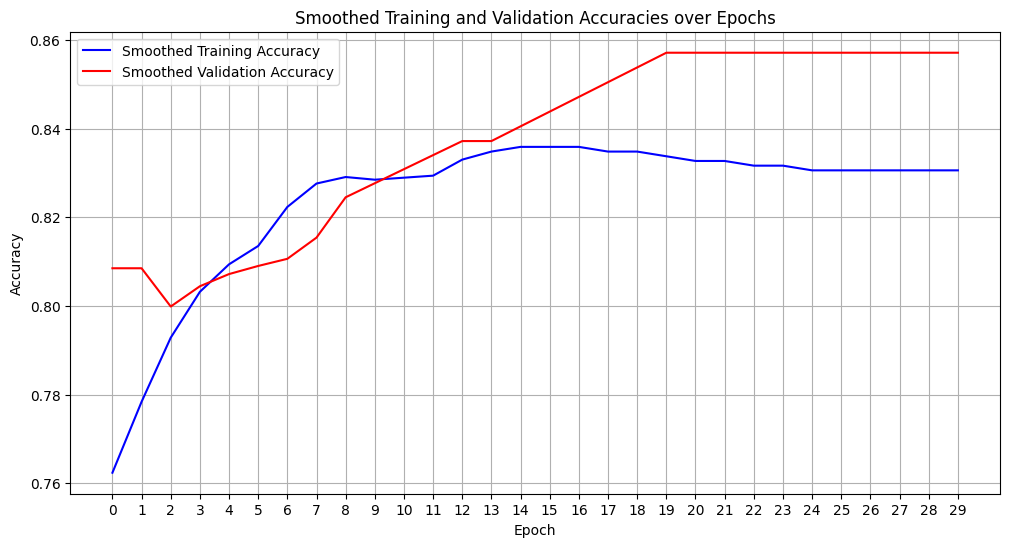

In [ ]:
def moving_average(data, window_size):
    """Compute the moving average of the given list."""
    return [np.mean(data[max(0, i - window_size) : (i + 1)]) for i in range(len(data))]


window_size = 5

smoothed_train_accuracies = moving_average(train_f1s, window_size)
smoothed_val_accuracies = moving_average(val_f1s, window_size)

plt.figure(figsize=(12, 6))
plt.plot(smoothed_train_accuracies, label="Smoothed Training Accuracy", color="blue")
plt.plot(smoothed_val_accuracies, label="Smoothed Validation Accuracy", color="red")
plt.title("Smoothed Training and Validation Accuracies over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(0, num_epochs))
plt.legend()
plt.grid(True)
plt.show()

### 2.3.2 Grid Search - Best possible Model, considering the grid search space

In [19]:
hyperparameters = {
    "num_layers": [1, 2, 3, 4],
    "learning_rate": [0.1, 0.01, 0.001],
    "layer_type": ["GraphConv", "AttentionConv", "GraphSAGEConv"],
    "hidden_features": [16, 32, 64],
    "pooling": ["mean", "max"],
}

num_epochs = 30
best_val_f1 = float(0)
best_params = None

for nl in hyperparameters["num_layers"]:
    for lr in hyperparameters["learning_rate"]:
        for lt in hyperparameters["layer_type"]:
            for hf in hyperparameters["hidden_features"]:
                for pooling in hyperparameters["pooling"]:
                    model = GraphClassifier(
                        in_features=7,
                        hidden_features=hf,
                        num_layers=nl,
                        layer_type=lt,
                        pooling=pooling,
                    )
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    best_val_f1_model = 0
                    best_val_f1_model_accuracy = 0

                    for epoch in range(num_epochs):
                        train_loss, train_accuracy, train_f1 = train(
                            model, train_loader, optimizer
                        )
                        val_loss, val_accuracy, val_f1 = evaluate(model, val_loader)

                        print(
                            f"Epoch {epoch+1}/{num_epochs}, Train F1: {train_f1}, Train Accuracy: {train_accuracy}, Val F1: {val_f1}, Val Accuracy: {val_accuracy}"
                        )

                        if val_f1 > best_val_f1:
                            best_val_f1 = val_f1
                            best_params = (nl, lr, lt, hf, pooling)
                            torch.save(model.state_dict(), "best_model_nodes.pt")

                        if val_f1 > best_val_f1_model:
                            best_val_f1_model = val_f1
                            best_val_f1_model_accuracy = val_accuracy

                    results = {
                        "name": str(lt)
                        + "_"
                        + str(nl)
                        + "_"
                        + str(lr)
                        + "_"
                        + str(hf)
                        + "_"
                        + str(pooling),
                        "num_layers": nl,
                        "learning_rate": lr,
                        "layer_type": lt,
                        "hidden_features": hf,
                        "pooling": pooling,
                        "val_accuracy": best_val_f1_model_accuracy,
                        "val_f1": best_val_f1_model,
                    }
                    all_results_nodes.append(results)
                    clear_output()
print(
    f"Best hyperparameters: Num Layers: {best_params[0]}, LR: {best_params[1]}, Layer Type: {best_params[2]}, Hidden Features: {best_params[3]}, Pooling: {best_params[4]}, with Val f1: {best_val_f1}"
)

Best hyperparameters: Num Layers: 3, LR: 0.001, Layer Type: GraphConv, Hidden Features: 16, Pooling: max, with Val f1: 0.9047619047619047


In [20]:
with open("results_nodes.csv", "w", newline="") as csvfile:
    fieldnames = [
        "name",
        "num_layers",
        "learning_rate",
        "layer_type",
        "hidden_features",
        "pooling",
        "val_accuracy",
        "val_f1",
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for row in all_results_nodes:
        writer.writerow(row)

## 2.4 Performance Evaluation

In [3]:
results_nodes = pd.read_csv("results_nodes.csv")
results_nodes.head()

,name,num_layers,learning_rate,layer_type,hidden_features,pooling,val_accuracy,val_f1
0,Baseline,1,0.01,GraphConv,32,mean,0.785714,0.857143
1,{lt}_{nl}_{lr}_{hf}_{pooling},1,0.10,GraphConv,16,mean,0.750000,0.844444
2,{lt}_{nl}_{lr}_{hf}_{pooling},1,0.10,GraphConv,16,max,0.678571,0.800000
3,{lt}_{nl}_{lr}_{hf}_{pooling},1,0.10,GraphConv,32,mean,0.750000,0.844444
4,{lt}_{nl}_{lr}_{hf}_{pooling},1,0.10,GraphConv,32,max,0.714286,0.826087


#### 2.4.1 Compare Layers

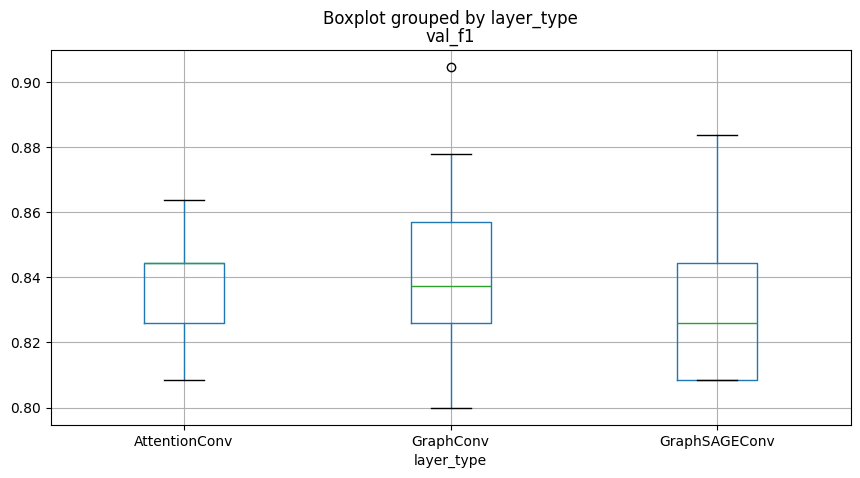

In [4]:
best_layer = results_nodes.drop(columns=["name", "pooling"])

box = best_layer.boxplot(column="val_f1", by="layer_type", figsize=(10, 5))

plt.show()

"AttentionConv" has the highest median val_f1 score. "GraphConv," while having some data points achieving higher val_f1 values, has a broader spread and a lower median, indicating greater variability. "GraphSAGEConv" offers a consistent range of values but trails behind both in terms of median performance. "AttentionConv" leads in performance, "GraphConv" displays variability with potential highs, and "GraphSAGEConv" provides slightly lower results. 

In [7]:
# compare means of the different layer types and display in a table
best_layer.groupby("layer_type").mean().drop(
    columns=["num_layers", "hidden_features", "learning_rate"]
)

,val_accuracy,val_f1
layer_type,,
AttentionConv,0.736607,0.837649
GraphConv,0.746086,0.839372
GraphSAGEConv,0.728175,0.830379


From this table we can see that GraphConv has slighly higher mean validation accuracy and f1-score. Considering that, and considering that the best f1 achieved was with GraphConv, I will you this as a layer in my best model.

#### 2.4.2 Compare Pooling Methods

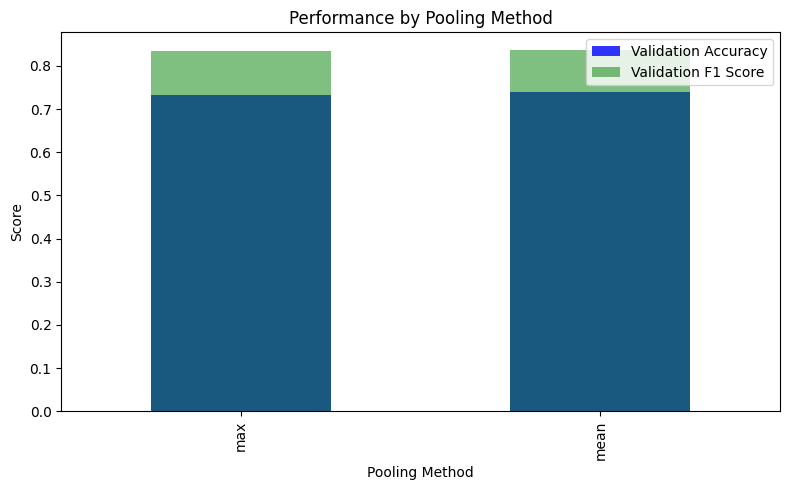

In [8]:
pooling_df = results_nodes.drop(columns=["name", "layer_type"])

grouped_pooling = pooling_df.groupby("pooling").mean()[["val_accuracy", "val_f1"]]

plt.figure(figsize=(8, 5))
grouped_pooling["val_accuracy"].plot(
    kind="bar", color="blue", label="Validation Accuracy", alpha=0.8
)
grouped_pooling["val_f1"].plot(
    kind="bar", color="green", label="Validation F1 Score", alpha=0.5
)
plt.title("Performance by Pooling Method")
plt.xlabel("Pooling Method")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

The performance by pooling does not differ significantly. A clear difference cannot be seen from this plot. Further analysis is required.

In [27]:
pooling_df = pooling_df.groupby("pooling").mean()[["val_accuracy", "val_f1"]]
pooling_df

,val_accuracy,val_f1
pooling,,
max,0.733796,0.835618
mean,0.740170,0.836012


They perform almost exactly the same, I will choose mean as the pooling method.

#### 2.4.3 Comparison between different Number of Hidden Features

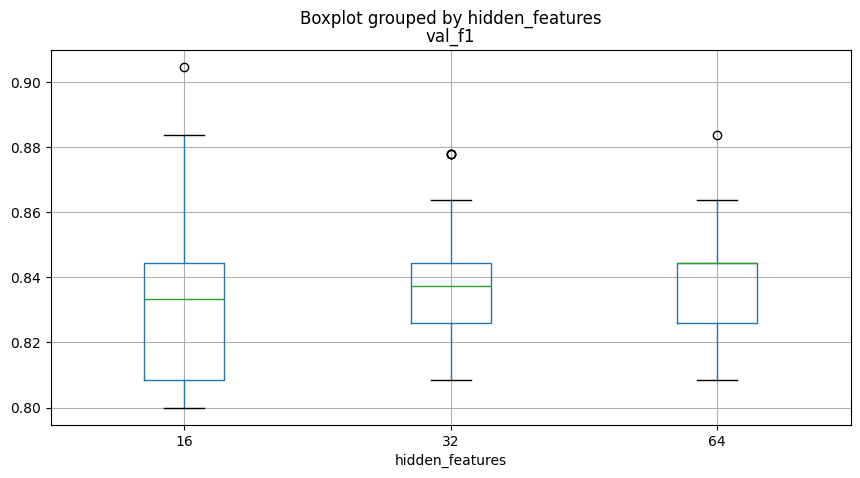

In [33]:
best_hidden_features = results_nodes.drop(columns=["name", "pooling", "layer_type"])

box = best_hidden_features.boxplot(
    column="val_f1", by="hidden_features", figsize=(10, 5)
)

plt.show()

The boxplot with 16 hidden features has the highest variance. As the number of hidden features increases the median also increases, so likely if we increase the number of hidden features the performance will increase. Although having 16 hidden features increases the variance, its maximum is the highest among the three.

#### 2.4.4 Evaluate the performance on the test set

In [17]:
best_model_nodes = GraphClassifier(
    in_features=7,
    hidden_features=16,
    num_layers=3,
    layer_type="GraphConv",
    pooling="max",
)

In [18]:
best_model_nodes.load_state_dict(torch.load("best_model_nodes.pt"))

<All keys matched successfully>

Baseline Model, Test F1: 0.7804878048780488, Test Accuracy: 0.6896551724137931


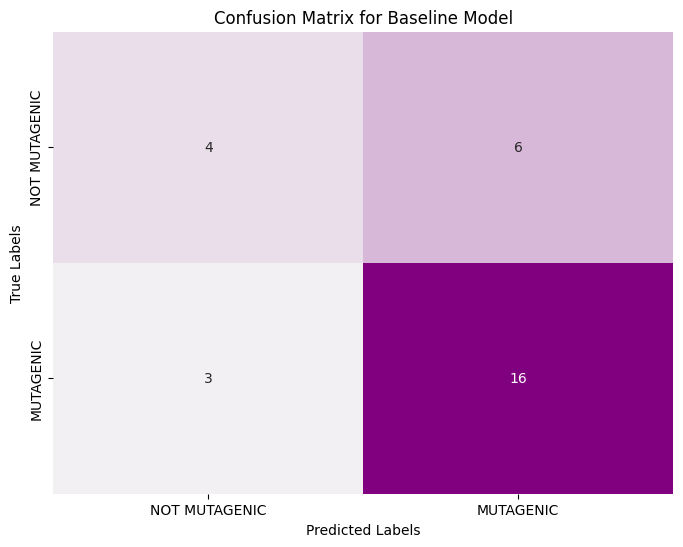

Best Model, Test F1: 0.8292682926829269, Test Accuracy: 0.7586206896551724


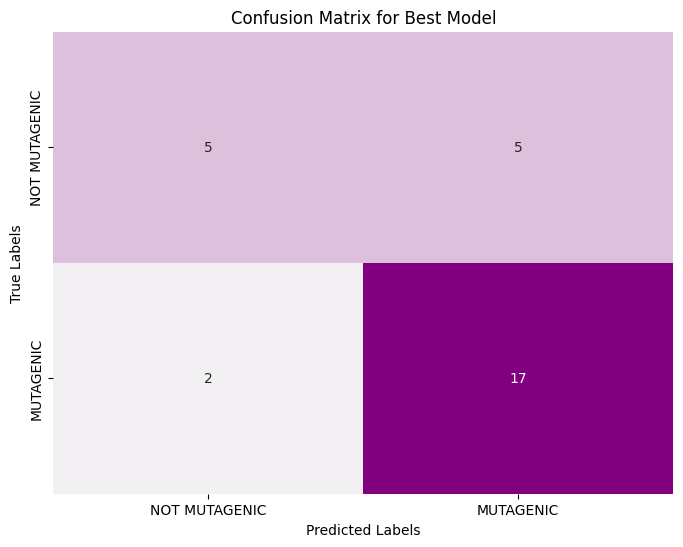

In [33]:
def plot_confusion_matrix(cm, title):
    muted_blues = sns.light_palette("purple", as_cmap=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="g",
        cmap=muted_blues,
        cbar=False,
        xticklabels=["NOT MUTAGENIC", "MUTAGENIC"],
        yticklabels=["NOT MUTAGENIC", "MUTAGENIC"],
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()


test_loss, test_accuracy_baseline, test_f1_baseline, cm1 = test(
    model, test_loader, nn.BCEWithLogitsLoss()
)
test_loss, test_accuracy_best, test_f1_best, cm2 = test(
    best_model_nodes, test_loader, nn.BCEWithLogitsLoss()
)

print(
    f"Baseline Model, Test F1: {test_f1_baseline}, Test Accuracy: {test_accuracy_baseline}"
)
plot_confusion_matrix(cm1, "Confusion Matrix for Baseline Model")

print(f"Best Model, Test F1: {test_f1_best}, Test Accuracy: {test_accuracy_best}")
plot_confusion_matrix(cm2, "Confusion Matrix for Best Model")

We can conclude that the hyperparameter optimization indeed worked, and the f1 score improved by ~5%, while the accuracy improved by ~7%

 With only 29 graphs, the validation set might not be representative of the entire data distribution. Any insights or conclusions drawn from it might not generalize well to a broader or different dataset. Small datasets are more susceptible to random variations. A few misclassifications or inaccuracies can have a more pronounced effect on metrics like the F1 Score. Even if a layer type seems to perform well on this small validation set, it doesn't necessarily mean it will perform equally well on a larger or different dataset. This problem can be mitigated with cross validation.

# Part 3: Incorporating Edge Features

## 3.1 Explain your strategy for incorporating edge features

Lets visualize the graphs but this time with edge features, hover the edges to show the features.

In [ ]:
mutagenic_graph = 0
visualize_graph_with_pyvis_edge_features(
    dataset_hf["train"],
    mutagenic_graph,
    name="mutagenic_graph.html",
)

webbrowser.open("edge_mutagenic_graph.html")

non_mutagenic_graph = 1
visualize_graph_with_pyvis_edge_features(
    dataset_hf["train"],
    non_mutagenic_graph,
    name="non_mutagenic_graph.html",
)

webbrowser.open("edge_non_mutagenic_graph.html")

# Note: I have to do it with webbrowser since there is an issue with pyvis and jupyter notebook in VSCode thats unsolved.

-------------------------

##### ** NOTE **: Instead of showing the code for all the methods i will just present the results and justify my choice based on that. You can find the code for all the methods at the bottom in section "Additional Code"

-------------------------

##### Methods for Edge Feature Aggregation

**<s>Method 1: Aggregate Edge Features and replace the 1s in the adjacency matrix with the aggregation</s>**

***Important Note about Method 1:*** This method does not make sense after further thought. Since the features are one hot encoded, if i do an aggregation, lets say max, i would still end up with the same value of 1 in the adjacency matrix since the max from `[0 1 0 0]` is 1. If i do mean i would get 0.25 instead of 1, but again thats not viable, since i do not provide additional information about the features other than "there is an edge, there is not an edge". This method would make sense if the features were not one hot encoded. I will still write the code and leave it at the bottom section, but i wont use it in the comparison.

**Method 2: Scalars Based on Edge Features Frequency** -
The straightforward approach is to compute the frequency of the vectors and assign a constant based on that frequency. For instance, if an edge feature vector `[1 0 0 0]` appears 138 times in the training set, `[0 1 0 0]` appears 130 times, and so on. I assign smaller constants to vectors with larger frequencies to emphasize rare vectors. This method is entirely speculative. It's uncertain whether emphasizing rare features is always the correct approach(its more of a "naive" approach since I assume that rare features are relevant), so relying solely on this method may not be optimal.

**Method 3: Node Feature Augmentation based on Edge Feature Aggregation** -
The idea is to compute aggregated edge attributes for each node in the graph and use them to augment the original node features. The aggregation can be done using operations like mean, max, or sum. Example: Node A with feature vector x = `[0 1 0 0 0 0 0]`, has 2 edges, e1 = `[0 0 1 0]` and e2 = `[1 0 0 0]`. PAIRWISE_MEAN(e1, e2) = `[0.5, 0, 0.5, 0]`. Augment Node A with the aggregated edge attributes. CONCAT(Node A, PAIRWISE_MEAN) = `[0 1 0 0 0 0 0 0.5 0 0.5 0]`.

**Method 4: Embed + Merge + Transform** -
Instead of relying on fixed scalars, a more advanced method uses learnable weights in the adjacency matrix. In this approach, we learn scalar weights for each combination of edge features and node features. First we use an embedding layer to learn to embed edge features in the same dimension as node features. Then a neural network takes the concatenated or merged features of edges and nodes as input and produces these scalar weights. Also a Tanh activation function within this neural network to introduce non-linearity. These weights, modulated by the Tanh activation, determine the significance of each edge feature in the context of its associated node features when aggregating information from neighboring nodes. This adaptability, with the added non-linearity, allows the model to assign varying degrees of importance to different combinations of edge and node features.




Reason for Choice: 
Given the uncertainty regarding the influence of a specific edge feature in determining whether a graph is MUTAGENIC, a promising approach is using a learnable weight. This weight aims to discern this "influence" during the learning phase. For the transformation, a Neural Network is employed.


------------

### 3.1.1 Evaluation of the different methods for incorporating edge features

In [11]:
results_edges_freq = pd.read_csv("results_edges_freq.csv")
results_edges_aggr_sum_to_nodes = pd.read_csv("results_edges_aggr_sum_to_nodes.csv")
results_edges_aggr_meanmax_to_nodes = pd.read_csv(
    "results_edges_aggr_meanmax_to_nodes.csv"
)
results_edges = pd.read_csv("results_edges_embed_transform.csv")

dataframes = {
    "results_edges_freq": results_edges_freq,
    "results_edges_aggr_sum_to_nodes": results_edges_aggr_sum_to_nodes,
    "results_edges_aggr_meanmax_to_nodes": results_edges_aggr_meanmax_to_nodes,
    "results_edges": results_edges,
}

df_samples = {key: df.head() for key, df in dataframes.items()}

In [12]:
summary = {
    "Edge Feature Implementation": [
        "Frequency",
        "Aggregated Sum + Concatenation",
        "Aggregated Mean/Max + Concatenation",
        "Embed + Merge + Transform",
    ],
    "Average Validation Accuracy": [
        results_edges_freq["val_accuracy"].mean(),
        results_edges_aggr_sum_to_nodes["val_accuracy"].mean(),
        results_edges_aggr_meanmax_to_nodes["val_accuracy"].mean(),
        results_edges["val_accuracy"].mean(),
    ],
    "Average F1 Score": [
        results_edges_freq["val_f1"].mean(),
        results_edges_aggr_sum_to_nodes["val_f1"].mean(),
        results_edges_aggr_meanmax_to_nodes["val_f1"].mean(),
        results_edges["val_f1"].mean(),
    ],
}

summary_df = pd.DataFrame(summary)
display(summary_df)

,Edge Feature Implementation,Average Validation Accuracy,Average F1 Score
0,Frequency,0.739253,0.837053
1,Aggregated Sum + Concatenation,0.752149,0.844497
2,Aggregated Mean/Max + Concatenation,0.730985,0.833505
3,Embed + Merge + Transform,0.788525,0.866932


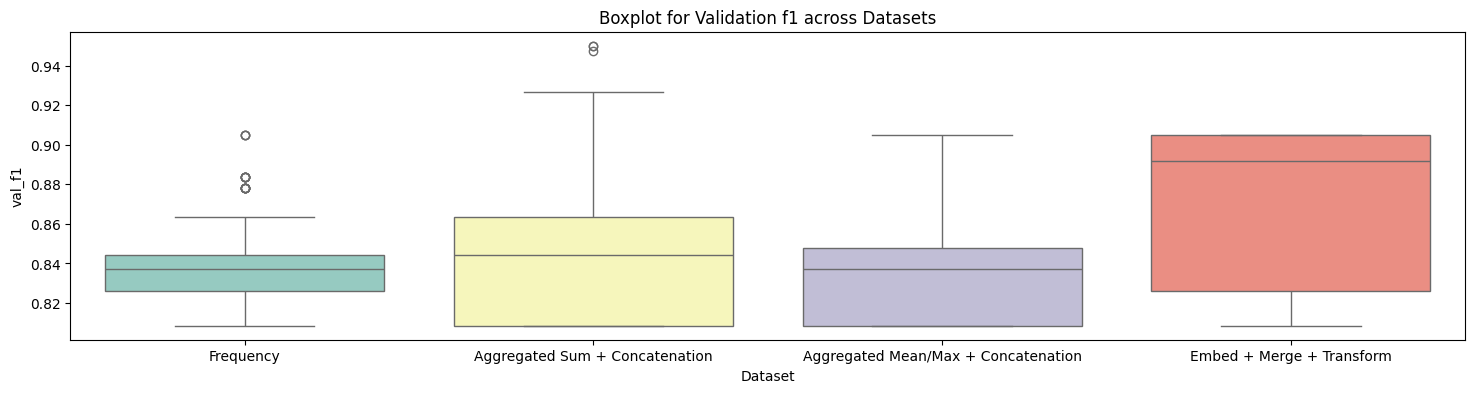

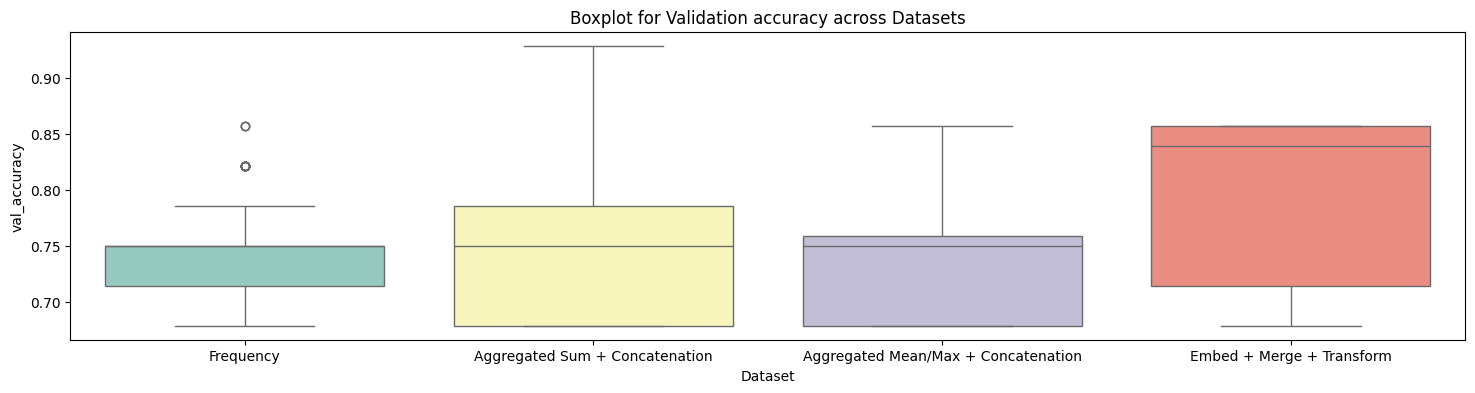

In [13]:
all_data = pd.concat([df.assign(Dataset=name) for name, df in dataframes.items()])

labels = summary["Edge Feature Implementation"]

plt.figure(figsize=(18, 4))
ax1 = sns.boxplot(
    data=all_data, x="Dataset", y="val_f1", hue="Dataset", palette="Set3", legend=False
)
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels)
plt.title("Boxplot for Validation f1 across Datasets")
plt.show()

plt.figure(figsize=(18, 4))
ax2 = sns.boxplot(
    data=all_data,
    x="Dataset",
    y="val_accuracy",
    hue="Dataset",
    palette="Set3",
    legend=False,
)
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels)
plt.title("Boxplot for Validation accuracy across Datasets")
plt.show()

In [320]:
# find max from each dataset:
max_f1 = all_data.groupby("Dataset").max()["val_f1"]
max_accuracy = all_data.groupby("Dataset").max()["val_accuracy"]
print(max_f1)
print(max_accuracy)

Dataset
results_edges                          0.904762
results_edges_aggr_meanmax_to_nodes    0.904762
results_edges_aggr_sum_to_nodes        0.950000
results_edges_freq                     0.904762
Name: val_f1, dtype: float64
Dataset
results_edges                          0.857143
results_edges_aggr_meanmax_to_nodes    0.857143
results_edges_aggr_sum_to_nodes        0.928571
results_edges_freq                     0.857143
Name: val_accuracy, dtype: float64


***Reason for choice*** - 
After careful consideration of the methods presented and the results obtained from them, the method chosen for implementation is Method 4: Embed + Merge + Transform.

***Justification*** - 
Method 4 excels in both Average Validation Accuracy 78% and F1 Score 86%, indicating its superior ability to balance precision and recall. Method 4 avoids the pitfalls of making assumptions on feature importance, unlike Method 2(Frequency), by learning directly from the data. Although, the maximum performance is achievied using Method 3, variant 1. This makes sense, since, both methods perform the exact same operation (sum) when merging edge features with node features, but according to the boxplot Method 4 is more stable. I will continue with the utilization of Method 4, and showcase the implementation in the following cells.

## 3.2 Modify your GNN to utilize Edge Features With The Chosen Method - Method 4

### 3.2.1 Normal Convolution

In [53]:
class GraphConvEdges(nn.Module):
    """Graph convolutional layer implementing the neighborhood aggregation with edge features."""

    def __init__(
        self, in_node_features, in_edge_features, out_features, activation=None
    ):
        """
        Initialize the graph convolutional layer.

        Args:
            in_node_features (int): number of input node features.
            in_edge_features (int): number of input edge features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        self.activation = activation

        self.weight = nn.Linear(in_node_features, out_features, bias=False)
        self.bias = nn.Linear(in_node_features, out_features, bias=False)

        # transform edge features to the same dimension as node features
        self.edge_embedding = nn.Linear(in_edge_features, in_node_features)
        # transform the combined features to scalar weights
        self.edge_transform = nn.Sequential(
            nn.Linear(in_node_features, 14),
            nn.ReLU(),
            nn.Linear(14, 1),
            nn.Tanh(),
        )

    def forward(self, x, adj):
        """
        Perform a forward pass through the graph convolutional layer.

        Args:
            x (torch.Tensor): The input node features of shape (N, in_node_features), where N is the number of nodes.
            adj (torch.Tensor): The adjacency matrix with edge features.

        Returns:
            torch.Tensor: The output node features after the graph convolution.
        """
        # embed edge features
        edge_embedded = self.edge_embedding(adj)

        # expand node features to align with edge shape for multiplication
        x_expanded = x.unsqueeze(1).expand(-1, x.size(0), -1)
        # merge
        node_edge_merged = x_expanded + edge_embedded

        # transform
        edge_weights = self.edge_transform(node_edge_merged).squeeze(-1)

        x_agg = torch.matmul(edge_weights, x)
        h_combined = self.weight(x_agg) + self.bias(x)

        if self.activation:
            return self.activation(h_combined)
        return h_combined

### 3.2.2 GraphSAGE

In [54]:
class GraphSAGEConvEdges(nn.Module):
    def __init__(
        self,
        in_node_features,
        in_edge_features,
        out_features,
        activation=None,
        aggregation="mean",
    ):
        """
        Initialize the GraphSAGE convolutional layer with edge features.

        Args:
            in_node_features (int): Number of input node features.
            in_edge_features (int): Number of input edge features.
            out_features (int): Number of output node features.
            activation (nn.Module or callable, optional): Activation function to apply. Default is None.
        """
        super(GraphSAGEConvEdges, self).__init__()
        self.aggregation = aggregation
        self.activation = activation
        self.weight = nn.Linear(2 * in_node_features, out_features)

        nn.init.xavier_uniform_(self.weight.weight)

        self.edge_embedding = nn.Linear(in_edge_features, in_node_features)
        self.edge_transform = nn.Sequential(
            nn.Linear(in_node_features, 14),
            nn.ReLU(),
            nn.Linear(14, 1),
            nn.Tanh(),
        )

    def forward(self, x, adj):
        """
        Perform a forward pass through the GraphSAGE convolutional layer.

        Args:
            x (torch.Tensor): The input node features.
            adj (torch.Tensor): The adjacency matrix with edge features.

        Returns:
            torch.Tensor: The output node features after the GraphSAGE convolution with edge consideration.
        """
        edge_embedded = self.edge_embedding(adj)

        x_expanded = x.unsqueeze(1).expand(-1, x.size(0), -1)
        node_edge_merged = x_expanded + edge_embedded

        edge_weights = self.edge_transform(node_edge_merged).squeeze(-1)

        x_agg = self.aggregate(x, edge_weights)

        x_concat = torch.cat([x, x_agg], dim=1)
        x_out = self.weight(x_concat)

        if self.activation:
            x_out = self.activation(x_out)

        return x_out

    def aggregate(self, x, adj):  # room for improvement
        """
        Args:
            x (torch.Tensor): The input features.
            adj (torch.Tensor): The adjacency matrix.

        Returns:
            torch.Tensor: The aggregated features.
        """
        # normalize adj matrix
        adj = adj / adj.sum(1, keepdim=True).clamp(min=1)
        if self.aggregation == "mean":
            x_agg = torch.matmul(adj, x)

        elif self.aggregation == "max":
            edge_index = torch.triu(adj).nonzero(as_tuple=False).t()
            x_agg = torch.zeros_like(x)
            # Loop on all nodes
            for i in range(x_agg.shape[0]):
                neighbors = x[edge_index[1, edge_index[0] == i]]
                if neighbors.shape[0] > 0:
                    x_agg[i] = neighbors.max(dim=0)[0]

        return x_agg

### 3.2.3 Attention-based Convolution

In [55]:
class AttentionConvEdges(nn.Module):
    def __init__(
        self, in_node_features, in_edge_features, out_features, activation=None
    ):
        """
        Initialize the attention convolutional layer with edge features.

        Args:
            in_node_features (int): Number of input node features.
            in_edge_features (int): Number of input edge features.
            out_features (int): Number of output node features.
            activation (nn.Module or callable, optional): Activation function to apply. Default is None.
        """
        super(AttentionConvEdges, self).__init__()

        self.activation = activation
        self.edge_embedding = nn.Linear(in_edge_features, in_node_features)
        self.edge_transform = nn.Sequential(
            nn.Linear(in_node_features, 14),
            nn.ReLU(),
            nn.Linear(14, 1),
            nn.Tanh(),
        )

        self.weight = nn.Parameter(torch.Tensor(in_node_features, out_features))
        nn.init.xavier_uniform_(self.weight.data, gain=1.414)

        # attention
        self.a = nn.Parameter(torch.Tensor(2 * out_features, 1))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU()

    def forward(self, x, adj):
        """
        Perform a forward pass through the attention convolutional layer.

        Args:
            x (torch.Tensor): The input node features.
            adj (torch.Tensor): The adjacency matrix with edge features.

        Returns:
            torch.Tensor: The output node features after applying the attention mechanism considering edge features.
        """
        h = torch.mm(x, self.weight)
        N = h.size()[0]

        # edge feature transformation
        edge_embedded = self.edge_embedding(adj)

        x_expanded = x.unsqueeze(1).expand(-1, x.size(0), -1)
        node_edge_merged = x_expanded + edge_embedded

        edge_weights = self.edge_transform(node_edge_merged).squeeze(-1)

        a_input = torch.cat(
            [h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1
        ).view(N, -1, 2 * h.size(1))
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # modulate attention scores using edge weights
        e = e * edge_weights

        I = torch.eye(N, device=adj.device)
        e = e.masked_fill(I.bool(), float("-inf"))

        attention = F.softmax(e, dim=1)

        h_prime = torch.matmul(attention, h)

        if self.activation is not None:
            h_prime = self.activation(h_prime)

        return h_prime

### 3.2.4 Custom(izable) Network Architecture

In [56]:
class GraphClassifierEdges(nn.Module):
    def __init__(
        self,
        in_features,
        edg_features,
        hidden_features,  # add this line to the parameters
        num_layers=2,
        layer_type="GraphConvEdges",  # changed the default
        pooling="mean",
    ):
        super(GraphClassifierEdges, self).__init__()

        self.layers = nn.ModuleList()

        for _ in range(num_layers):
            if layer_type == "GraphConvEdges":
                self.layers.append(
                    GraphConvEdges(
                        in_features if len(self.layers) == 0 else hidden_features,
                        in_edge_features=edg_features,  # account for edge features
                        out_features=hidden_features,
                        activation=F.relu,
                    )
                )
            elif layer_type == "AttentionConvEdges":
                self.layers.append(
                    AttentionConvEdges(
                        in_features if len(self.layers) == 0 else hidden_features,
                        in_edge_features=edg_features,  # account for edge features
                        out_features=hidden_features,
                    )
                )
            elif layer_type == "GraphSAGEConvEdges":
                self.layers.append(
                    GraphSAGEConvEdges(
                        in_features if len(self.layers) == 0 else hidden_features,
                        in_edge_features=edg_features,  # account for edge features
                        out_features=hidden_features,
                        activation=F.relu,
                    )
                )

        if pooling == "mean":
            self.pooling = mean_pooling
        elif pooling == "max":
            self.pooling = max_pooling
        else:
            raise ValueError("Invalid pooling type.")

        self.fc = nn.Linear(hidden_features, 1)  # Binary classification

    def forward(self, x, adj):
        """
        Forward propagation for the graph.

        Args:
            x (Tensor): Node features, shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix, shape (num_nodes, num_nodes).
            edge_features (Tensor): Edge features, shape (num_nodes, num_nodes, edge_features).

        Returns:
            Tensor: Binary prediction for the entire graph, shape (1).
        """
        for layer in self.layers:
            x = layer(x, adj)

        x = self.pooling(x)

        x = self.fc(x)
        return x

### 3.2.5 Hyperparameter Optimization

In [299]:
all_results_edges = []

hyperparameters = {
    "num_layers": [1, 2, 3, 4],
    "learning_rate": [0.1, 0.01, 0.001],
    "layer_type": ["GraphConvEdges", "AttentionConvEdges", "GraphSAGEConvEdges"],
    "hidden_features": [16, 32, 64],
    "pooling": ["mean", "max"],
}

num_epochs = 30
best_val_f1 = float(0)
best_params = None

for nl in hyperparameters["num_layers"]:
    for lr in hyperparameters["learning_rate"]:
        for lt in hyperparameters["layer_type"]:
            for hf in hyperparameters["hidden_features"]:
                for pooling in hyperparameters["pooling"]:
                    model = GraphClassifierEdges(
                        in_features=7,
                        edg_features=4,
                        hidden_features=hf,
                        num_layers=nl,
                        layer_type=lt,
                        pooling=pooling,
                    )
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    best_val_f1_model = 0
                    best_val_f1_model_accuracy = 0

                    for epoch in range(num_epochs):
                        train_loss, train_accuracy, train_f1 = train_edges(
                            model, train_loader, optimizer
                        )
                        val_loss, val_accuracy, val_f1 = evaluate_edges(
                            model, val_loader
                        )

                        print(
                            f"Epoch {epoch+1}/{num_epochs}, Train F1: {train_f1}, Train Accuracy: {train_accuracy}, Val F1: {val_f1}, Val Accuracy: {val_accuracy}"
                        )

                        if val_f1 > best_val_f1:
                            best_val_f1 = val_f1
                            best_params = (nl, lr, lt, hf, pooling)
                            torch.save(model.state_dict(), "best_model_edges.pt")

                        if val_f1 > best_val_f1_model:
                            best_val_f1_model = val_f1
                            best_val_f1_model_accuracy = val_accuracy

                    results = {
                        "name": str(lt)
                        + "_"
                        + str(nl)
                        + "_"
                        + str(lr)
                        + "_"
                        + str(hf)
                        + "_"
                        + str(pooling),
                        "num_layers": nl,
                        "learning_rate": lr,
                        "layer_type": lt,
                        "hidden_features": hf,
                        "pooling": pooling,
                        "val_accuracy": best_val_f1_model_accuracy,
                        "val_f1": best_val_f1_model,
                    }

                    all_results_edges.append(results)
                    clear_output()
print(
    f"Best hyperparameters: Num Layers: {best_params[0]}, LR: {best_params[1]}, Layer Type: {best_params[2]}, Hidden Features: {best_params[3]}, Pooling: {best_params[4]}, with Val f1: {best_val_f1}"
)

Best hyperparameters: Num Layers: 1, LR: 0.1, Layer Type: GraphConvEdges, Hidden Features: 16, Pooling: mean, with Val f1: 0.9047619047619047


In [300]:
with open("results_edges_embed_transform.csv", "w", newline="") as csvfile:
    fieldnames = [
        "name",
        "num_layers",
        "learning_rate",
        "layer_type",
        "hidden_features",
        "pooling",
        "val_accuracy",
        "val_f1",
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for row in all_results_edges:
        writer.writerow(row)

### 3.2.6 Performance Evaluation

For the performance evaluation, i will use: Methods' 4 best model, and Method 3 Variant 1 - the overall best performing model we saw above.

##### 3.2.6.1 Overall Performance Evaluation

In [48]:
results_nodes_df = pd.read_csv("results_nodes.csv")
results_edges_embed_transform_df = pd.read_csv("results_edges_embed_transform.csv")
results_edges_aggr_sum_to_nodes_df = pd.read_csv("results_edges_aggr_sum_to_nodes.csv")

metrics_nodes = results_nodes_df[["name", "val_accuracy", "val_f1"]]
metrics_edges_embed_transform = results_edges_embed_transform_df[
    ["name", "val_accuracy", "val_f1"]
]
metrics_edges_aggr_sum_to_nodes = results_edges_aggr_sum_to_nodes_df[
    ["name", "val_accuracy", "val_f1"]
]

avg_performance = {
    "Method": [
        "Nodes",
        "Edge 1 : Embed + Merge + Transform",
        "Edge 2 : Aggr. to Nodes (Sum)",
    ],
    "Average Val Accuracy": [
        metrics_nodes["val_accuracy"].mean(),
        metrics_edges_embed_transform["val_accuracy"].mean(),
        metrics_edges_aggr_sum_to_nodes["val_accuracy"].mean(),
    ],
    "Average Val F1": [
        metrics_nodes["val_f1"].mean(),
        metrics_edges_embed_transform["val_f1"].mean(),
        metrics_edges_aggr_sum_to_nodes["val_f1"].mean(),
    ],
}

avg_performance_df = pd.DataFrame(avg_performance)
avg_performance_df

,Method,Average Val Accuracy,Average Val F1
0,Nodes,0.736998,0.835816
1,Edge 1 : Embed + Merge + Transform,0.788525,0.866932
2,Edge 2 : Aggr. to Nodes (Sum),0.752149,0.844497


From the table, we can observe that:

-The "Embed + Merge + Transform" method has the highest average validation accuracy and F1 score.<br>
-The "Nodes Only" method has the lowest average validation accuracy and F1 score.<br>
-The "Edge Aggr. to Nodes (Sum)" method provides performance in between the other two methods.<br>
This suggests that using edge features, especially with the "Embed + Merge + Transform" method, does improve performance compared to just using node features alone.

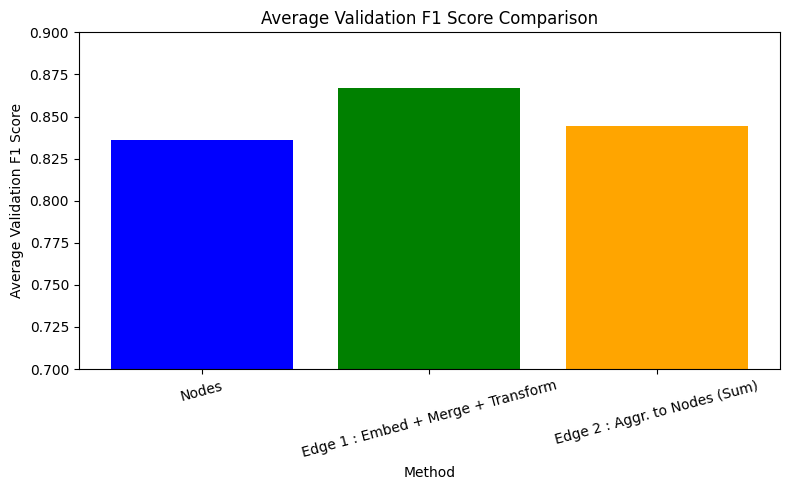

In [51]:
plt.figure(figsize=(8, 5))

plt.bar(
    avg_performance_df["Method"],
    avg_performance_df["Average Val F1"],
    color=["blue", "green", "orange"],
)
plt.xlabel("Method")
plt.ylabel("Average Validation F1 Score")
plt.title("Average Validation F1 Score Comparison")
plt.ylim(0.7, 0.9)
plt.xticks(rotation=15)
plt.tight_layout()

plt.show()

Here's the bar plot comparing the average validation F1 score for each method. Again, the "Embed + Merge + Transform" method shows superior performance in terms of the F1 score.

##### 3.2.6.2 Best Model Performance Evaluation

In [64]:
top_model_nodes = results_nodes_df.loc[results_nodes_df["val_f1"].idxmax()]
top_model_edges_embed_transform = results_edges_embed_transform_df.loc[
    results_edges_embed_transform_df["val_f1"].idxmax()
]
top_model_edges_aggr_sum_to_nodes = results_edges_aggr_sum_to_nodes_df.loc[
    results_edges_aggr_sum_to_nodes_df["val_f1"].idxmax()
]

top_models_df = pd.concat(
    [
        top_model_nodes,
        top_model_edges_embed_transform,
        top_model_edges_aggr_sum_to_nodes,
    ],
    axis=1,
).T
top_models_df = top_models_df[["name", "val_accuracy", "val_f1"]]
top_models_df.columns = ["Model Name", "Validation Accuracy", "Top Validation F1 Score"]
top_models_df["Model Name"] = [
    "Nodes Only",
    "Edge 1 : Embed + Merge + Transform",
    "Edge 2 : Edge Aggr. to Nodes (Sum)",
]

top_models_df

,Model Name,Validation Accuracy,Top Validation F1 Score
146,Nodes Only,0.857143,0.904762
0,Edge 1 : Embed + Merge + Transform,0.857143,0.904762
75,Edge 2 : Edge Aggr. to Nodes (Sum),0.928571,0.95


 "Edge Aggr. to Nodes (Sum)" method's top model outperformed the other methods in both validation accuracy and F1 score.

##### 3.2.6.3 Evaluate the performance on the test set

In [57]:
best_model_method_4 = GraphClassifierEdges(  # initialize this based on best_params
    in_features=7,
    edg_features=4,
    hidden_features=16,
    num_layers=1,
    layer_type="GraphConvEdges",
    pooling="mean",
)
best_model_method_4.load_state_dict(torch.load("best_model_edges.pt"))
best_model_method_3 = GraphClassifier(
    in_features=11,
    hidden_features=32,
    num_layers=2,
    layer_type="GraphConv",
    pooling="max",
)
best_model_method_3.load_state_dict(torch.load("best_model_edges_aggr_sum_to_nodes.pt"))
best_model_nodes = GraphClassifier(
    in_features=7,
    hidden_features=16,
    num_layers=3,
    layer_type="GraphConv",
    pooling="max",
)
best_model_nodes.load_state_dict(torch.load("best_model_nodes.pt"))

<All keys matched successfully>

Method 4 - Test F1: 0.8205128205128205, Test Accuracy: 0.7586206896551724


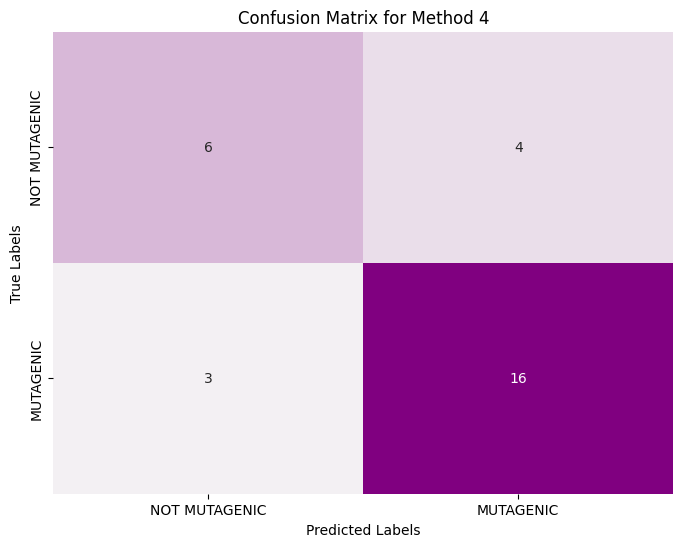

Method 3 - Test F1: 0.8717948717948718, Test Accuracy: 0.8275862068965517


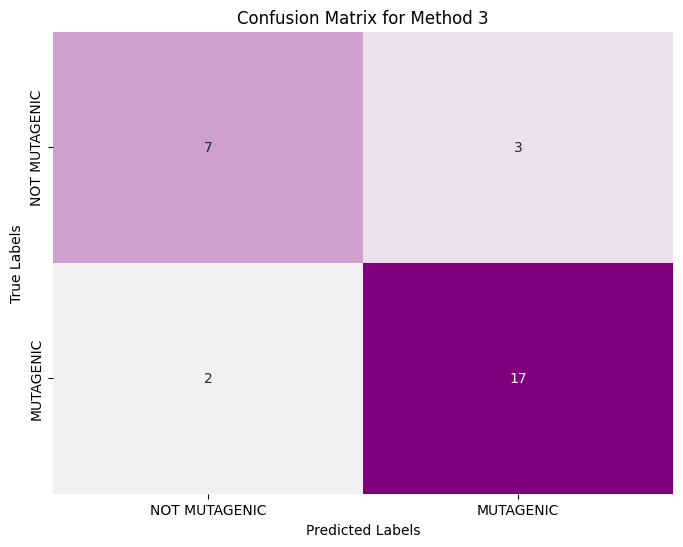

Best Nodes Model - Test F1: 0.8292682926829269, Test Accuracy: 0.7586206896551724


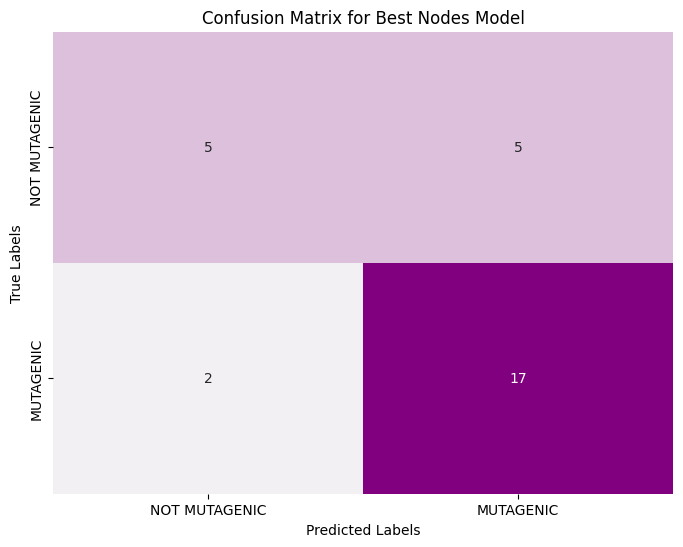

In [58]:
test_loss_m4, test_accuracy_m4, test_f1_m4, cm1 = test_edges(
    best_model_method_4, test_loader, nn.BCEWithLogitsLoss()
)
test_loss_m3, test_accuracy_m3, test_f1_m3, cm2 = test_add_edge_to_nodes(
    best_model_method_3, test_loader
)
test_loss, test_accuracy_nodes_best, test_f1_nodes_best, cm3 = test(
    best_model_nodes, test_loader, nn.BCEWithLogitsLoss()
)

print(f"Method 4 - Test F1: {test_f1_m4}, Test Accuracy: {test_accuracy_m4}")
plot_confusion_matrix(cm1, "Confusion Matrix for Method 4")
print(f"Method 3 - Test F1: {test_f1_m3}, Test Accuracy: {test_accuracy_m3}")
plot_confusion_matrix(cm2, "Confusion Matrix for Method 3")
print(
    f"Best Nodes Model - Test F1: {test_f1_nodes_best}, Test Accuracy: {test_accuracy_nodes_best}"
)
plot_confusion_matrix(cm3, "Confusion Matrix for Best Nodes Model")

***Final Remark*** - Incorporating edge features into the model does enhance performance, as seen from the results above. Its interesting that a straightforward aggregation of edge features to nodes outperformed a more intricate embedding and transformation process. But when looking at the overall picture the later outperforms the former. It's essential to highlight the sample size's potential implications on the validity of the results. With only around 28 samples each for validation and testing, the results may carry a degree of uncertainty. Future experiments with larger datasets would provide more robust and generalized insights.

## Additional Code

### <s> Implementing Edge Features Using Method 1: Aggregate Edge Features - ILLOGICAL! </s>

/comment/: These stay the same as in the node features part (Part 1). The only thing that should be changed is adding an aggregation (mean, max, sum) to the adjacency matrix and then using that as an input to the model.

In [309]:
# 1.1 GraphConv
class GraphConvEdges(nn.Module):
    """Basic graph convolutional layer implementing the simple neighborhood aggregation."""

    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the graph convolutional layer.

        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        self.activation = activation

        self.weight = nn.Linear(in_features, out_features, bias=False)
        nn.init.xavier_uniform_(self.weight.weight)
        self.bias = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        adj = adj / adj.sum(1, keepdim=True).clamp(min=1)
        x_agg = torch.matmul(adj, x)

        x = self.weight(x_agg) + self.bias(x)

        if self.activation is not None:
            x = self.activation(x)
        return x


## 1.2 GraphSAGE
class GraphSAGEConvEdges(nn.Module):
    def __init__(self, in_features, out_features, activation=None):
        super(GraphSAGEConvEdges, self).__init__()

        self.weight = nn.Linear(2 * in_features, out_features)
        nn.init.xavier_uniform_(self.weight.weight)
        self.activation = activation

    def forward(self, x, adj):
        x_agg = self.aggregate(x, adj)

        x_concat = torch.cat([x, x_agg], dim=1)

        x_out = self.weight(x_concat)

        if self.activation:
            x_out = self.activation(x_out)

        return x_out

    def aggregate(self, x, adj):
        """
        This function performs the neighborhood aggregation.
        """
        adj = adj / adj.sum(1, keepdim=True).clamp(min=1)
        x_agg = torch.matmul(adj, x)
        return x_agg


## 1.3 Attention-based Convolution
class AttentionConvEdges(nn.Module):
    def __init__(self, in_features, out_features):
        super(AttentionConvEdges, self).__init__()

        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        nn.init.xavier_uniform_(self.weight.data, gain=1.414)

        self.a = nn.Parameter(torch.Tensor(2 * out_features, 1))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU()

    def forward(self, x, adj):
        h = torch.mm(x, self.weight)
        N = h.size()[0]

        a_input = torch.cat(
            [h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1
        ).view(N, -1, 2 * h.size(1))
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        I = torch.eye(N, device=adj.device)
        e = e.masked_fill(I.bool(), float("-inf"))

        attention = F.softmax(e, dim=1)

        h_prime = torch.matmul(attention, h)

        return h_prime

/comment/: This also stays the same

In [313]:
class GraphClassifierEdges(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features,
        num_layers=2,
        layer_type="GraphConvEdges",  # default
        pooling="mean",  # default
    ):
        """
        Initialize the Graph Classifier.

        Args:
            in_features (int): Number of input node features.
            hidden_features (int): Number of hidden node features.
            num_layers (int): Number of graph convolutional layers.
            layer_type (str): Type of graph convolutional layer ('GraphConv', 'AttentionConv', 'GraphSAGEConv').
            pooling (str): Pooling method ('mean' or 'max').
        """
        super(GraphClassifierEdges, self).__init__()

        self.layers = nn.ModuleList()

        for _ in range(num_layers):
            if layer_type == "GraphConvEdges":
                self.layers.append(
                    GraphConvEdges(
                        in_features if len(self.layers) == 0 else hidden_features,
                        hidden_features,
                        F.relu,
                    )
                )
            elif layer_type == "AttentionConvEdges":
                self.layers.append(
                    AttentionConvEdges(
                        in_features if len(self.layers) == 0 else hidden_features,
                        hidden_features,
                    )
                )
            elif layer_type == "GraphSAGEConvEdges":
                self.layers.append(
                    GraphSAGEConvEdges(
                        in_features if len(self.layers) == 0 else hidden_features,
                        hidden_features,
                        F.relu,
                    )
                )

        if pooling == "mean":
            self.pooling = mean_pooling
        elif pooling == "max":
            self.pooling = max_pooling
        else:
            raise ValueError("Invalid pooling type.")

        self.fc = nn.Linear(hidden_features, 1)

    def forward(self, x, adj):
        """
        Forward propagation for the graph.

        Args:
            x (Tensor): Node features, shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Binary prediction for the entire graph, shape (1).
        """

        for layer in self.layers:
            x = layer(x, adj)

        x = self.pooling(x)

        x = self.fc(x)

        return x

/comment/: Changes, line 21 and 61. According to the method you want to use, you just uncomment/comment. Possible methods max/sum/mean 

In [34]:
### This code block should be in train_test_val_loops.py file, but im showing it here for clarity


def train_with_aggr_edges(
    model, train_loader, optimizer, criterion=nn.BCEWithLogitsLoss(), threshold=0.5
):
    model.train()
    train_loss = 0.0

    true_labels, preds = (
        [],
        [],
    )

    for batch in train_loader:
        x, edge_index, edge_attr, labels, adj_matrix, adj_matrix_edges = batch
        x = x[0]
        labels = labels[0].float()
        # adj_matrix_edges = torch.mean(adj_matrix_edges[0], dim=2)
        # If you want to use sum or max, just comment the above line and uncomment the desired line below:
        # adj_matrix_edges = torch.sum(adj_matrix_edges[0], dim=2)
        adj_matrix_edges, _ = torch.max(adj_matrix_edges[0], dim=2)

        # adj_matrix_edges = adj_matrix_edges[0]
        outputs = model(x, adj_matrix_edges)
        outputs = outputs.squeeze(-1)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        probs = torch.sigmoid(outputs)
        predictions = (probs > threshold).float()

        true_labels.extend(labels.cpu().numpy())
        preds.extend(predictions.cpu().numpy())

    train_accuracy = accuracy_score(true_labels, preds)
    train_f1 = f1_score(true_labels, preds)
    return train_loss / len(train_loader), train_accuracy, train_f1


def evaluate_with_aggr_edges(
    model, val_loader, criterion=nn.BCEWithLogitsLoss(), threshold=0.5
):
    model.eval()
    val_loss = 0.0
    val_labels, val_preds = [], []
    with torch.no_grad():
        for batch in val_loader:
            x, edge_index, edge_attr, labels, adj_matrix, adj_matrix_edges = batch

            x = x[0]
            labels = labels[0].float()
            # adj_matrix_edges = adj_matrix_edges[0]
            # adj_matrix_edges = torch.mean(adj_matrix_edges[0], dim=2)
            # If you want to use sum or max, just comment the above line and uncomment the desired line below:
            # adj_matrix_edges = torch.sum(adj_matrix_edges[0], dim=2)
            adj_matrix_edges, _ = torch.max(adj_matrix_edges[0], dim=2)

            outputs = model(x, adj_matrix_edges)
            outputs = outputs.squeeze(-1)

            val_loss += criterion(outputs, labels).item()

            probs = torch.sigmoid(outputs)
            predictions = (probs > threshold).float()
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predictions.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)
    return val_loss / len(val_loader), val_accuracy, val_f1

/comment/: The hyperparameter loop remains unchanged

In [35]:
all_results_edges_max = []

hyperparameters = {
    "num_layers": [1, 2, 3, 4],
    "learning_rate": [0.1, 0.01, 0.001],
    "layer_type": ["GraphConvEdges", "AttentionConvEdges", "GraphSAGEConvEdges"],
    "hidden_features": [16, 32, 64],
    "pooling": ["mean", "max"],
}

num_epochs = 30
best_val_f1 = float(0)
best_params = None

for nl in hyperparameters["num_layers"]:
    for lr in hyperparameters["learning_rate"]:
        for lt in hyperparameters["layer_type"]:
            for hf in hyperparameters["hidden_features"]:
                for pooling in hyperparameters["pooling"]:
                    model = GraphClassifierEdges(
                        in_features=7,
                        hidden_features=hf,
                        num_layers=nl,
                        layer_type=lt,
                        pooling=pooling,
                    )
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    best_val_f1_model = 0
                    best_val_f1_model_accuracy = 0

                    for epoch in range(num_epochs):
                        train_loss, train_accuracy, train_f1 = train_with_aggr_edges(
                            model, train_loader, optimizer
                        )
                        val_loss, val_accuracy, val_f1 = evaluate_with_aggr_edges(
                            model, val_loader
                        )

                        print(
                            f"Epoch {epoch+1}/{num_epochs}, Train F1: {train_f1}, Train Accuracy: {train_accuracy}, Val F1: {val_f1}, Val Accuracy: {val_accuracy}"
                        )

                        if val_f1 > best_val_f1:
                            best_val_f1 = val_f1
                            best_params = (nl, lr, lt, hf, pooling)
                            torch.save(model.state_dict(), "best_model_edges_max.pt")

                        if val_f1 > best_val_f1_model:
                            best_val_f1_model = val_f1
                            best_val_f1_model_accuracy = val_accuracy

                    results = {
                        "name": str(lt)
                        + "_"
                        + str(nl)
                        + "_"
                        + str(lr)
                        + "_"
                        + str(hf)
                        + "_"
                        + str(pooling),
                        "num_layers": nl,
                        "learning_rate": lr,
                        "layer_type": lt,
                        "hidden_features": hf,
                        "pooling": pooling,
                        "val_accuracy": best_val_f1_model_accuracy,
                        "val_f1": best_val_f1_model,
                    }

                    all_results_edges_max.append(results)
                    clear_output()
print(
    f"Best hyperparameters: Num Layers: {best_params[0]}, LR: {best_params[1]}, Layer Type: {best_params[2]}, Hidden Features: {best_params[3]}, Pooling: {best_params[4]}, with Val f1: {best_val_f1}"
)

Best hyperparameters: Num Layers: 4, LR: 0.01, Layer Type: GraphConvEdges, Hidden Features: 64, Pooling: mean, with Val f1: 0.9047619047619047


In [36]:
with open("results_edges_max.csv", "w", newline="") as csvfile:
    fieldnames = [
        "name",
        "num_layers",
        "learning_rate",
        "layer_type",
        "hidden_features",
        "pooling",
        "val_accuracy",
        "val_f1",
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for row in all_results_edges_max:
        writer.writerow(row)

### Implementing Edge Features Using Method 2: Scalars(Constants) Based on Frequency of Edge Features

The layers and the model remain unchanged

In [37]:
edg_feats = []
xs = []

for batch in train_loader:
    edg_feats.append(batch[2])
    xs.append(batch[0])

num_features = 4
patterns = [torch.zeros(num_features) for _ in range(num_features)]
for i in range(num_features):
    patterns[i][i] = 1.0

count_frequencies = {str(pattern.tolist()): 0 for pattern in patterns}

for graph in edg_feats:
    for pattern in patterns:
        count_frequencies[str(pattern.tolist())] += torch.sum(
            (graph == pattern).all(dim=1)
        ).item()

print(count_frequencies)

{'[1.0, 0.0, 0.0, 0.0]': 130, '[0.0, 1.0, 0.0, 0.0]': 140, '[0.0, 0.0, 1.0, 0.0]': 140, '[0.0, 0.0, 0.0, 1.0]': 10}


/comment/: In this case i will use count frequency since its loaded in this notebook. But if i were to use this as a function i would send it as an argument. 

In [38]:
def train_with_freq_edges(
    model, train_loader, optimizer, criterion=nn.BCEWithLogitsLoss(), threshold=0.5
):
    model.train()
    train_loss = 0.0

    true_labels, preds = (
        [],
        [],
    )

    sorted_patterns = sorted(
        count_frequencies.keys(), key=lambda k: count_frequencies[k], reverse=True
    )

    # mapping from pattern to rank
    pattern_to_rank = {
        pattern: rank + 1 for rank, pattern in enumerate(sorted_patterns)
    }

    for batch in train_loader:
        x, edge_index, edge_attr, labels, adj_matrix, adj_matrix_edges = batch
        x = x[0]
        labels = labels[0].float()

        edge_attr_matrix = edge_attr[0]
        for edge, value in zip(edge_index[0].t(), edge_attr_matrix):
            source, target = edge
            pattern_str = str(value.tolist())
            if pattern_str in pattern_to_rank:
                rank = pattern_to_rank[pattern_str]
                adj_matrix_edges[0][source][target] = rank
                adj_matrix_edges[0][target][source] = rank

        outputs = model(x, adj_matrix_edges)
        outputs = outputs.squeeze(-1)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        probs = torch.sigmoid(outputs)
        predictions = (probs > threshold).float()

        true_labels.extend(labels.cpu().numpy())
        preds.extend(predictions.cpu().numpy())

    train_accuracy = accuracy_score(true_labels, preds)
    train_f1 = f1_score(true_labels, preds)
    return train_loss / len(train_loader), train_accuracy, train_f1


def evaluate_with_freq_edges(
    model, val_loader, criterion=nn.BCEWithLogitsLoss(), threshold=0.5
):
    model.eval()
    val_loss = 0.0
    val_labels, val_preds = [], []

    sorted_patterns = sorted(
        count_frequencies.keys(), key=lambda k: count_frequencies[k], reverse=True
    )

    # Create a mapping from pattern to rank
    pattern_to_rank = {
        pattern: rank + 1 for rank, pattern in enumerate(sorted_patterns)
    }

    with torch.no_grad():
        for batch in val_loader:
            x, edge_index, edge_attr, labels, adj_matrix, adj_matrix_edges = batch

            x = x[0]
            labels = labels[0].float()
            edge_attr_matrix = edge_attr[0]
            for edge, value in zip(edge_index[0].t(), edge_attr_matrix):
                source, target = edge
                pattern_str = str(value.tolist())
                if pattern_str in pattern_to_rank:
                    rank = pattern_to_rank[pattern_str]
                    adj_matrix_edges[0][source][target] = rank
                    adj_matrix_edges[0][target][
                        source
                    ] = rank  # Assuming undirected graphs

            outputs = model(x, adj_matrix_edges)
            outputs = outputs.squeeze(-1)

            val_loss += criterion(outputs, labels).item()

            probs = torch.sigmoid(outputs)
            predictions = (probs > threshold).float()
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predictions.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)
    return val_loss / len(val_loader), val_accuracy, val_f1

In [39]:
all_results_edges_freq = []

hyperparameters = {
    "num_layers": [1, 2, 3, 4],
    "learning_rate": [0.1, 0.01, 0.001],
    "layer_type": ["GraphConvEdges", "AttentionConvEdges", "GraphSAGEConvEdges"],
    "hidden_features": [16, 32, 64],
    "pooling": ["mean", "max"],
}

num_epochs = 30
best_val_f1 = float(0)
best_params = None

for nl in hyperparameters["num_layers"]:
    for lr in hyperparameters["learning_rate"]:
        for lt in hyperparameters["layer_type"]:
            for hf in hyperparameters["hidden_features"]:
                for pooling in hyperparameters["pooling"]:
                    model = GraphClassifierEdges(
                        in_features=7,
                        hidden_features=hf,
                        num_layers=nl,
                        layer_type=lt,
                        pooling=pooling,
                    )
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    best_val_f1_model = 0
                    best_val_f1_model_accuracy = 0

                    for epoch in range(num_epochs):
                        train_loss, train_accuracy, train_f1 = train_with_aggr_edges(
                            model, train_loader, optimizer
                        )
                        val_loss, val_accuracy, val_f1 = evaluate_with_aggr_edges(
                            model, val_loader
                        )

                        print(
                            f"Epoch {epoch+1}/{num_epochs}, Train F1: {train_f1}, Train Accuracy: {train_accuracy}, Val F1: {val_f1}, Val Accuracy: {val_accuracy}"
                        )

                        if val_f1 > best_val_f1:
                            best_val_f1 = val_f1
                            best_params = (nl, lr, lt, hf, pooling)
                            torch.save(model.state_dict(), "best_model_edges_freq.pt")

                        if val_f1 > best_val_f1_model:
                            best_val_f1_model = val_f1
                            best_val_f1_model_accuracy = val_accuracy

                    results = {
                        "name": str(lt)
                        + "_"
                        + str(nl)
                        + "_"
                        + str(lr)
                        + "_"
                        + str(hf)
                        + "_"
                        + str(pooling),
                        "num_layers": nl,
                        "learning_rate": lr,
                        "layer_type": lt,
                        "hidden_features": hf,
                        "pooling": pooling,
                        "val_accuracy": best_val_f1_model_accuracy,
                        "val_f1": best_val_f1_model,
                    }

                    all_results_edges_freq.append(results)
                    clear_output()
print(
    f"Best hyperparameters: Num Layers: {best_params[0]}, LR: {best_params[1]}, Layer Type: {best_params[2]}, Hidden Features: {best_params[3]}, Pooling: {best_params[4]}, with Val f1: {best_val_f1}"
)

Best hyperparameters: Num Layers: 1, LR: 0.001, Layer Type: GraphConvEdges, Hidden Features: 16, Pooling: max, with Val f1: 0.9047619047619047


In [40]:
with open("results_edges_freq.csv", "w", newline="") as csvfile:
    fieldnames = [
        "name",
        "num_layers",
        "learning_rate",
        "layer_type",
        "hidden_features",
        "pooling",
        "val_accuracy",
        "val_f1",
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for row in all_results_edges_freq:
        writer.writerow(row)

### Implementing Edge Features Using Method 3: Node Feature Augmentation based on Edge Feature Aggregation, Variant 1 and 2

/comment/: Again the layers and the model remain unchanged. The change occurs when initializing the model, we initialize it with 11 instead of 7, since we concatenate the aggregated edge features with the node features. The second change occurs in the train and eval, where we find the edges related to a node and aggregate them with the chosen method.

Variant 1: I use sum to aggregate

In [318]:
def train_add_edge_to_nodes(
    model, train_loader, optimizer, criterion=nn.BCEWithLogitsLoss(), threshold=0.5
):
    model.train()
    train_loss = 0.0

    true_labels, preds = [], []

    for batch in train_loader:
        x, edge_index, edge_attr, labels, adj_matrix, _ = batch
        x = x[0]
        labels = labels[0].float()
        adj_matrix = adj_matrix[0]
        # aggregate the edge attributes
        aggregated_attributes = aggregate_edge_features_by_node(
            x, edge_index, edge_attr
        )

        # Augment or replace node features with aggregated attributes
        # Here's an example where we concatenate them:
        x_combined = torch.cat([x, aggregated_attributes], dim=1)
        outputs = model(x_combined, adj_matrix)
        outputs = outputs.squeeze(-1)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        probs = torch.sigmoid(outputs)
        predictions = (probs > threshold).float()

        true_labels.extend(labels.cpu().numpy())
        preds.extend(predictions.cpu().numpy())

    train_accuracy = accuracy_score(true_labels, preds)
    train_f1 = f1_score(true_labels, preds)
    return train_loss / len(train_loader), train_accuracy, train_f1


def evaluate_add_edge_to_nodes(
    model, val_loader, criterion=nn.BCEWithLogitsLoss(), threshold=0.5
):
    model.eval()
    val_loss = 0.0
    val_labels, val_preds = [], []
    with torch.no_grad():
        for batch in val_loader:
            x, edge_index, edge_attr, labels, adj_matrix, _ = batch

            x = x[0]
            labels = labels[0].float()
            adj_matrix = adj_matrix[0]
            # aggregate the edge attributes
            aggregated_attributes = aggregate_edge_features_by_node(
                x, edge_index, edge_attr
            )

            # Augment or replace node features with aggregated attributes
            # Here's an example where we concatenate them:
            x_combined = torch.cat([x, aggregated_attributes], dim=1)
            outputs = model(x_combined, adj_matrix)
            outputs = outputs.squeeze(-1)

            val_loss += criterion(outputs, labels).item()

            probs = torch.sigmoid(outputs)
            predictions = (probs > threshold).float()
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predictions.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)
    return val_loss / len(val_loader), val_accuracy, val_f1

In [62]:
all_results_edges_aggr_sum_to_nodes = (
    []
)  # change in accordance to the aggregation method

hyperparameters = {
    "num_layers": [1, 2, 3, 4],
    "learning_rate": [0.1, 0.01, 0.001],
    "layer_type": ["GraphConvEdges", "AttentionConvEdges", "GraphSAGEConvEdges"],
    "hidden_features": [16, 32, 64],
    "pooling": ["mean", "max"],
}

num_epochs = 30
best_val_f1 = float(0)
best_params = None

for nl in hyperparameters["num_layers"]:
    for lr in hyperparameters["learning_rate"]:
        for lt in hyperparameters["layer_type"]:
            for hf in hyperparameters["hidden_features"]:
                for pooling in hyperparameters["pooling"]:
                    model = GraphClassifierEdges(
                        in_features=11,  # Its 11 since we add the edge attributes to the node features
                        hidden_features=hf,
                        num_layers=nl,
                        layer_type=lt,
                        pooling=pooling,
                    )
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    best_val_f1_model = 0
                    best_val_f1_model_accuracy = 0

                    for epoch in range(num_epochs):
                        train_loss, train_accuracy, train_f1 = train_add_edge_to_nodes(
                            model, train_loader, optimizer
                        )
                        val_loss, val_accuracy, val_f1 = evaluate_add_edge_to_nodes(
                            model, val_loader
                        )

                        print(
                            f"Epoch {epoch+1}/{num_epochs}, Train F1: {train_f1}, Train Accuracy: {train_accuracy}, Val F1: {val_f1}, Val Accuracy: {val_accuracy}"
                        )

                        if val_f1 > best_val_f1:
                            best_val_f1 = val_f1
                            best_params = (nl, lr, lt, hf, pooling)
                            torch.save(
                                model.state_dict(),
                                "best_model_edges_aggr_sum_to_nodes.pt",
                            )

                        if val_f1 > best_val_f1_model:
                            best_val_f1_model = val_f1
                            best_val_f1_model_accuracy = val_accuracy

                    results = {
                        "name": str(lt)
                        + "_"
                        + str(nl)
                        + "_"
                        + str(lr)
                        + "_"
                        + str(hf)
                        + "_"
                        + str(pooling),
                        "num_layers": nl,
                        "learning_rate": lr,
                        "layer_type": lt,
                        "hidden_features": hf,
                        "pooling": pooling,
                        "val_accuracy": best_val_f1_model_accuracy,
                        "val_f1": best_val_f1_model,
                    }

                    all_results_edges_aggr_sum_to_nodes.append(results)
                    clear_output()
print(
    f"Best hyperparameters: Num Layers: {best_params[0]}, LR: {best_params[1]}, Layer Type: {best_params[2]}, Hidden Features: {best_params[3]}, Pooling: {best_params[4]}, with Val f1: {best_val_f1}"
)

Best hyperparameters: Num Layers: 2, LR: 0.01, Layer Type: GraphConvEdges, Hidden Features: 32, Pooling: max, with Val f1: 0.9500000000000001


In [63]:
with open("results_edges_aggr_sum_to_nodes.csv", "w", newline="") as csvfile:
    fieldnames = [
        "name",
        "num_layers",
        "learning_rate",
        "layer_type",
        "hidden_features",
        "pooling",
        "val_accuracy",
        "val_f1",
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for row in all_results_edges_aggr_sum_to_nodes:
        writer.writerow(row)

Variant 2: I use mean aggregation AND max aggregation and then i combine them in a single vector (of size 8) and then i concatenate that vector to the node features. So basically a combination of mean and max, the idea was to preserve the pros from doing these types of aggregation.

Example: if a node has 2 edges with features: `[0 0 1 0]` and `[0 1 0 0]`, the resulting mean aggregation would be `[0, 0.5 0.5 0]` and the max `[0, 1, 1, 0]` => and the concatenation of this two `[0, 0.5, 0.5, 0, 0, 1, 1, 0]`. This is then concatenated with the node feature vector.

In [12]:
def aggregate_edge_features_by_node(
    x, edge_index, edge_attr
):  # I just change the function to do mean max intead of sum.
    edge_index = edge_index.squeeze(0)  # Removing batch dimension
    edge_attr = edge_attr.squeeze(0)

    num_nodes = x.size(0)
    num_features = edge_attr.size(-1)

    aggregated_sum = torch.zeros(num_nodes, num_features).to(x.device)
    aggregated_count = torch.zeros(num_nodes).to(x.device)

    for i in range(edge_index.size(1)):
        src = edge_index[0, i].item()
        aggregated_sum[src] += edge_attr[i]
        aggregated_count[src] += 1

    # mean aggregation
    aggregated_mean = aggregated_sum / (
        aggregated_count.unsqueeze(-1) + 1e-9
    )  # Adding small value to prevent division by zero

    # max aggregation
    aggregated_max = torch.max(aggregated_mean, dim=0)[0]

    # combination
    aggregated_attributes = torch.cat(
        [aggregated_mean, aggregated_max.unsqueeze(0).repeat(num_nodes, 1)], dim=1
    )

    return aggregated_attributes

In [15]:
results_edges_aggr_meanmax_to_nodes = (
    []
)  # change in accordance to the aggregation method

hyperparameters = {
    "num_layers": [1, 2, 3, 4],
    "learning_rate": [0.1, 0.01, 0.001],
    "layer_type": ["GraphConvEdges", "AttentionConvEdges", "GraphSAGEConvEdges"],
    "hidden_features": [16, 32, 64],
    "pooling": ["mean", "max"],
}

num_epochs = 30
best_val_f1 = float(0)
best_params = None

for nl in hyperparameters["num_layers"]:
    for lr in hyperparameters["learning_rate"]:
        for lt in hyperparameters["layer_type"]:
            for hf in hyperparameters["hidden_features"]:
                for pooling in hyperparameters["pooling"]:
                    model = GraphClassifierEdges(
                        in_features=15,  # ITS 15 SINCE WE ADD THE EDGE ATTRIBUTES TO THE NODE FEATURES
                        hidden_features=hf,
                        num_layers=nl,
                        layer_type=lt,
                        pooling=pooling,
                    )
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    best_val_f1_model = 0
                    best_val_f1_model_accuracy = 0

                    for epoch in range(num_epochs):
                        train_loss, train_accuracy, train_f1 = train_add_edge_to_nodes(
                            model, train_loader, optimizer
                        )
                        val_loss, val_accuracy, val_f1 = evaluate_add_edge_to_nodes(
                            model, val_loader
                        )

                        print(
                            f"Epoch {epoch+1}/{num_epochs}, Train F1: {train_f1}, Train Accuracy: {train_accuracy}, Val F1: {val_f1}, Val Accuracy: {val_accuracy}"
                        )

                        if val_f1 > best_val_f1:
                            best_val_f1 = val_f1
                            best_params = (nl, lr, lt, hf, pooling)
                            torch.save(
                                model.state_dict(),
                                "best_model_edges_aggr_meanmax_to_nodes.pt",
                            )

                        if val_f1 > best_val_f1_model:
                            best_val_f1_model = val_f1
                            best_val_f1_model_accuracy = val_accuracy

                    results = {
                        "name": str(lt)
                        + "_"
                        + str(nl)
                        + "_"
                        + str(lr)
                        + "_"
                        + str(hf)
                        + "_"
                        + str(pooling),
                        "num_layers": nl,
                        "learning_rate": lr,
                        "layer_type": lt,
                        "hidden_features": hf,
                        "pooling": pooling,
                        "val_accuracy": best_val_f1_model_accuracy,
                        "val_f1": best_val_f1_model,
                    }

                    results_edges_aggr_meanmax_to_nodes.append(results)
                    clear_output()
print(
    f"Best hyperparameters: Num Layers: {best_params[0]}, LR: {best_params[1]}, Layer Type: {best_params[2]}, Hidden Features: {best_params[3]}, Pooling: {best_params[4]}, with Val f1: {best_val_f1}"
)

Best hyperparameters: Num Layers: 2, LR: 0.01, Layer Type: GraphConvEdges, Hidden Features: 64, Pooling: max, with Val f1: 0.9047619047619047


In [16]:
with open("results_edges_aggr_meanmax_to_nodes.csv", "w", newline="") as csvfile:
    fieldnames = [
        "name",
        "num_layers",
        "learning_rate",
        "layer_type",
        "hidden_features",
        "pooling",
        "val_accuracy",
        "val_f1",
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for row in results_edges_aggr_meanmax_to_nodes:
        writer.writerow(row)